# Tutorial on the Annotated Transformer
http://nlp.seas.harvard.edu/2018/04/03/attention.html

From the Author:

The Transformer from “Attention is All You Need” has been on a lot of people’s minds over the last year. 
Besides producing major improvements in translation quality, it provides a new architecture for many other NLP tasks. 
The paper itself is very clearly written, but the conventional wisdom has been that it is quite difficult to implement correctly.
In this post I present an “annotated” version of the paper in the form of a line-by-line implementation...

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [2]:
import math, copy, time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_context(context="talk")

Number of operations required to relate signals from two arbitrary input:
1. ConvS2S: linear
2. ByteNet: logarithmic
3. Transformer: constant, at the cost of reduced effective resolution due to averaging attention-weighted positions, counteract with multi-headed attention.

Self-attention has been used successfully in:
1. reading comprehension;
2. abstractive summerization;
3. textual entailment;
4. task-indenpendent sentence representations;

Me: Attention is commonly used with recurrence. 
Author: To the best of our knowledge, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its and input and output without using sequence aligned RNNs or convolution

##  Model Architecture

In [3]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture.
    Base for this and mnay other models
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder 
        self.decoder = decoder 
        # we have to first embed the source and target
        # and send the embedded source to encoder and
        # embedded target to the decoder.
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        # generator converts the output embedding 
        # from the decoder to vocabulary
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        """
        Take in and process masked source and target sequences.
        """
        # MORE ANNOTATION HERE, ESPECIALLY FOR THE MASKS
        memory = self.encode(src, src_mask)
        output = self.decode(memory, src_mask, tgt, tgt_mask)
        return output

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

## Embedding and Generator
Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension $d_{\textrm{model}}$. 
We also use the usual learned linear transformation and softmax function to convert the decoder output to predicted next-token probabilities. 
In our model, we share the same weight between the two embedding layers and the pre-softmax linear transform.
**In the embedding layers, we multiply those weights by $\sqrt{d_{\textrm{model}}}$. (Why?)**


In [4]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        """
        Input:
            - d_model (int): the embedding dimension
            - vocab (int): size of the vocabulary. (Yi) we have to think about this part, we don't have a fixed sized vocabulary
        """
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        # x = x.type(torch.LongTensor)
        return self.lut(x) * math.sqrt(self.d_model)

class Generator(nn.Module):
    """
    Define standard linear + softmax generation step.
    """
    def __init__(self, d_model, vocab):
        """
        d_model: MORE ANNOTATION HERE
        vocab: MORE ANNOTATION HERE
        """
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder and Decoder Stacks
cloning, layernormalization, and residual connection

In [5]:
def clones(module, N):
    """
    Produce N identical layers.
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

    
class LayerNorm(nn.Module):
    def __init__(self, size, eps=1e-6):
        """
        Construct a layernorm module
        Input:
            - size (int): The size of the last dimension of the input (x) to forward. 
                Since a_2 and b_2 have to be trainable parameters, we have to pass size
                at initialization instead of getting it from x.
            - eps (float): added to the denominator (std) to avoid dividing by zero.
        """
        super(LayerNorm, self).__init__()
        # a_2 and b_2 are parameters that are trainable
        # nn.Parameter(tensor, required_grad=True)
        self.a_2 = nn.Parameter(torch.ones(size))
        self.b_2 = nn.Parameter(torch.zeros(size))
        self.eps = eps

    def forward(self, x):
        """
        Calculate the mean and std along the last dimension, 
        and keep the dimension (e.g. 3x5x2 to 3x5x1, instead of 3x5)
        NOTE: for two TENSORS to be addable, they must match on the last dimension.
        """
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        x_normalized = (x - mean) / (std + self.eps)
        return  x_normalized * self.a_2 + self.b_2


class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    NOTE 1: For code simplicity, we do norm first as opposed to last.
    NOTE 2: (Yi) ViTGAN followed this norm-first approach
    """
    def __init__(self, size, dropout):
        """
        Input:
            - size: the embedding dimension of a word (or token);
            - dropout (float): probability of an element to be zeroed (default: .5).
        """
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        """
        Apply residual connection to any sublayer with the same size.
        """
        return x + self.dropout(sublayer(self.norm(x)))

### Encoder
The encoder is composed of a stack of $N = 6$ identical layers.

To faciliate residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimesion $d_{\textrm{model}} = 512$

In [29]:
class EncoderLayer(nn.Module):
    """
    Encoder is made up of two major blocks: 
        - self-attention, and
        - feed forward.
    """
    def __init__(self, size, self_attn, feed_forward, dropout):
        """
        Input:
            - size: the embedding dimension of a word (or token);
            - self_attn: self-attention layers
            - feed_forward: feed-forward layers
            - dropout (float): probability of an element to be zeroed (default: .5)
        """
        super(EncoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        

    def forward(self, x, mask):
        """
        Input:
            - x (tensor): the Key (K), Value (V), and Query (Q) matrix. For self-attention, we can have all three of them identical.
            - mask: We use matrices K and Q to generate scores. 
                However, we can only allow a token to attend to tokens generated no latter than itself. 
                Hence, we have to mask the score vector so that only values in values after i are zerod out in the softmax
        """
        # the self attention sublayer
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        # the feed forward sublayer
        x = self.sublayer[1](x, self.feed_forward)
        return x


class Encoder(nn.Module):    
    def __init__(self, layer, N):
        """
        Core encoder is a stack of N (default=6) layers.
        input:
            - layer (class nn.Module): the transformer encoder block
            - N (int): the number of transformer encoder blocks
        """
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        """
        Pass the input (and mask) through each layer in turn.
        Input:
            - x (tensor): the input tnesor
            - mask (function): the mask function to at
            print(x.shape)
            print(mask.shape)tention
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

### Decoder
The decoder is also composed of a stack of $N = 6$ identical layers

In [30]:
class DecoderLayer(nn.Module):
    """
    Decoder is made of self-attn, src-attn, and feed forward
    """
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
    
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        x = self.sublayer[2](x, self.feed_forward)
        return x

class Decoder(nn.Module):
    """
    Generic N-layered decoder with masking.
    """
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            print(x.shape)
            print(memory.shape)
            print(src_mask.shape)
            print(tgt_mask.shape)
            input()
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequence positions.

This masking, combined with the fact that output embeddings are offset by one position, ensures that the predictions for positions $i$ can depend only on the known outputs at positions less than $i$.

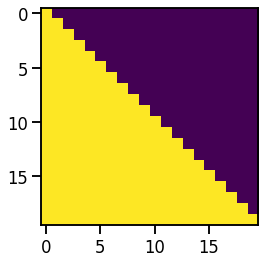

In [8]:
def subsequent_mask(size):
    """
    Mask out subsequence positions
    """
    attn_shape = (1, size, size)
    # make a upper triangular tensor
    # k is the offset from diagonal
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0
# example
plt.imshow(subsequent_mask(20)[0])

## Attention
An attention function can be described as mapping a query and a set of key-value pairs to an output,
where query, keys, values, and output are all vectors. 
The output is computed as a weighted sum of the values, where the weight assinged to each values is computed by a compatibility function of the query with the corresponding key.

We call our particular attention "Scaled dot-product attention". 

The input consists of 
1. queries of dimension $d_k$
2. keys of dimension $d_k$, and 
3. values of dimension $d_v$.

We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.
In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix $Q$. The keys and values are also packed together into matrices $K$ and $V$.
We compute the matrix of output as:
$$\textrm{Attention}(Q, K, V) = \textrm{softmax}(\frac{QK^{T}}{\sqrt{d_k}})V$$

types of attension:
1. additive attention -- compatibility is calculated using a feed-forward network
2. multiplicative attention-- equivalent to scaled dot-product attention without the scaling;
3. scaled dot-product attention

In [9]:
def attention(query, key, value, mask=None, dropout=None):
    """
    Compute the scaled dot-product attention
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        # mask_fill(mask, value_to_fill)
        # since we are using softmax, fill the score with a really negative number will make the probability close to zero
        # NOTE: About the mask
        # - mask and the tensor to be mask MUST have the same number of dimensions, i.e. mask and tensor must both be n-dimensional
        # - Suppose the tensor is of shape (3, 4, 2, 8)
        #   then the mask can have shape (3, 1, 1, 8)
        #   The requirement is that the size of mask must match the size of tensor at all non-singleton.
        #   That is, we cannot have mask of shape (3, 2, 1, 8) for tensor of shape (3, 4, 2, 8).
        #   We broadcast behavior on non-singleton dimension to the singleton dimension(s).
        #   This explains why we generate source masking and target masking in the different way.
        #   Source masking actually do not mask anything;
        #   But target masking need to mask all words come after.

        scores = scores.masked_fill(mask == 0, -1e9)

    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions.
**With a single attention head, averaging inhibits this (What averaging and why?).**

$$\textrm{MultiHead}(Q, K, V) = \textrm{Contact}(\textrm{head}_1,\dots, \textrm{head}_h)W^{o}$$

where 

$$\textrm{head}_i = \textrm{Attention}(QW_i^Q, KW_i^K, VW_i^V)$$

where the projections are parameter (learnable) matrices $W_i^{Q}\in\mathbb{R}^{d_{\textrm{model}}\times d_k}$, $W_i^{K}\in\mathbb{R}^{d_{\textrm{model}}\times d_k}$,  $W_i^{V}\in\mathbb{R}^{d_{\textrm{model}}\times d_v}$, and $W^{O}\in \mathbb{R}^{hd_v\times d_{\textrm{model}}}$.

In this work, we employ $h = 8$ parallel attention layers, or heads.
For each of these we use $d_k = d_v = d_{\textrm{model}} / h = 64$. 

Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimension.

In [10]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=.1):
        """
        Take in model size and number of head
        Input:
            - h (int): number of attention heads;
            - d_model (int): dimension of the output from the model
            - dropout (float): 
        """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0, "d_model must be a multiple of the number of heads (h)"
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query = self.linears[0](query).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        key = self.linears[1](key).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
        value = self.linears[2](value).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)

        # 2) Apply attention on all the projected vectors in batch
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) Concatenate using a vew and apply a final linear
        # contiguous() makes a copy of the tensor whose memory layout is confirmed to its shape
        x = x.transpose(1, 2).contiguous()
        x = x.view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

## Application of Attention in our Model
The Transformer uses multi-head attention in three different ways:
1. In "encoder-decoder" attention layers, the queries come from the previous decoder layer, and the memory keys and values come from the output of the encoder. 
    This allows every position in the decoder to attend over all poistions in the nput sequence. 
    This minics the typical encoder-decoder attention mechanisms in squenece-to-sequence models.
2. The encoder contains self-attention layer.
    In a self-attention layers all of the keys, values, and queries come from the same place -- the output of hte previous layer in the encoder.
    Each position in the encoder can attend to all positions in the previous layer of the encoder.
3. Similarly, self-attention layes in the decoder allow each position in the decoder to attend to all positions in the decoder up to that position.
    We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. 
    We implement this inside of the scaled dot-product attention by masking out (setting to $-\infty$) all values in the input of the soft max which correspond to illegal connections.

## Position-wise Feed-Forward Networks

In [11]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=.1):
        super(PositionWiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

## Positional Encoding

Since our model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information about the relative or absolute position of the tokens in the sequence. 
To this end, we add "positional encodings" to the input embeddings at the bottoms of the encoder and decoder stacks.
The positional encodings have the same dimension $d_{\textrm{model}}$ as the embeddings, so that the two can be summed. 

There are many choices of positional encodings, **learned (how)** and fixed.

In this work, we use sine and cosine functions of different frequencies: 
$$PE_{(pos, 2i)} = sin(\frac{pos}{10000^{2i/d_{\textrm{model}}}}),\quad PE_{(pos, 2i + 1)} = cos(\frac{pos}{10000^{2i/d_{\textrm{model}}}})$$
where $pos$ is the position and $i$ is the dimension. 

That is, each dimension of the positional encoding corresponds to a sinusoid. 
The wavelengths form a geometric progression from $2\pi$ to **$10000 \cdot 2\pi$. (why? Almost, not exactly, right?)**

We choose this function because we hypothensized it would allow the model to easily learn to attend by relative positions, since for any offset $k$, $PE_{pos + k}$ can be represnted as a linear functions of $PE_{pos}$.

**In addition, we apply dropout to the sums of the embeddings and the positional encodings in both the encoder and decoder stacks. (Why?)**
For the base model, we use a rate of $P_{drop} = .1$

We also experimented with using [learned positional embeddings](https://arxiv.org/pdf/1705.03122.pdf) instead, and found that two versions produced nearly identical results.
We choose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered during training.

In [12]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1) # make a max_len x 1 tensor where the [i, 0] entry equaling i
        div_term = torch.exp(-torch.arange(0, d_model, 2) * math.log(10000) / d_model) # 1 / denominator 
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)

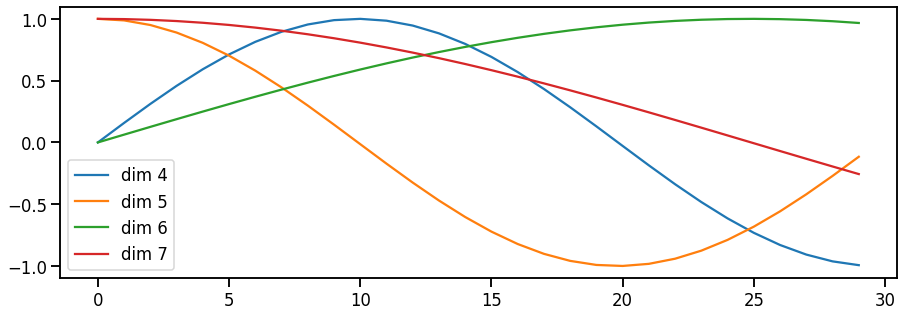

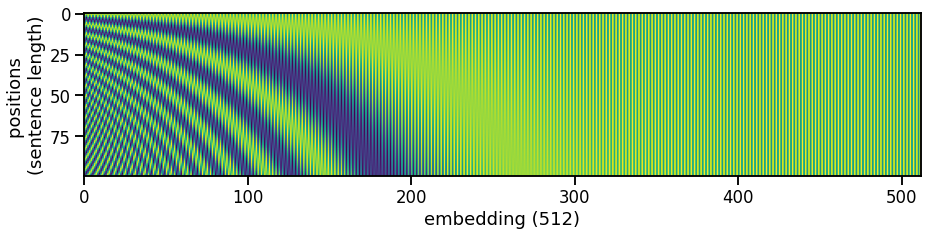

In [31]:
# y = pe.forward(Variable(torch.zeros(1, 100, 20)))
length = 30
d_model = 20
pe = PositionalEncoding(d_model, 0)
y = pe.forward(torch.zeros(1, length, d_model))

plt.figure(figsize=(15, 5))
plt.plot(np.arange(length), y[0, :, 4:8].data.numpy())
plt.legend([f'dim {p}' for p in range(4, 8)])

# Plot a position matrix
length = 100
d_model = 512
pe = PositionalEncoding(d_model, 0)
y = pe.forward(torch.zeros(1, length, d_model))
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.set_xlabel('embedding (512)')
ax.set_ylabel('positions \n(sentence length)')
ax.imshow(y[0][:, :])

plt.savefig('figures/position_matrix_fixed_sinusoidal.png', dpi=300, bbox_inches='tight', transparent=True)

## Full Model

In [25]:
def make_model(
    src_vocab, 
    tgt_vocab, 
    N=6, 
    d_model=512, 
    d_ff=2048, 
    h=8, 
    dropout=.1):
    """
    Construct a model from hyperparameters
    """

    C = copy.deepcopy

    attn = MultiHeadedAttention(h, d_model)
    ff = PositionWiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)

    encoder = Encoder(EncoderLayer(d_model, C(attn), C(ff), dropout), N)
    decoder = Decoder(DecoderLayer(d_model, C(attn), C(attn), C(ff), dropout), N)
    model = EncoderDecoder(
        encoder,
        decoder,
        nn.Sequential(Embeddings(d_model, src_vocab), C(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), C(position)),
        Generator(d_model, tgt_vocab)
    )

    # (author of this blog): This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

# Training
This section decribes the training regime for our models

We stop for a quick interlude to introduce some of the tools needed to train a standard encoder-decoder model.
First, we define a batch object that holds the source and target sentences for training, as well as constructing the masks

## Batch and Masking

In [14]:
class Batch:
    """
    Object for holding a batch of data with mask during training.
    """
    def __init__(self, src, tgt=None, pad=0):
        """
        Input:
            - src ():
            - tgt ():
            - pad ():
        NOTE: Make sure you know what are the src_mask and tgt_mask are for.
        """
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)

        if tgt is not None:
            # (what is this)
            self.tgt = tgt[:, :-1]
            # (What is this)
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        """
        Creat a mask to hide padding and future words
        """
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        
        return tgt_mask

Next we creat a generaic training and scoring function to keep track of loss.
WE pass in a generic loss compute function that also handles parameter updates.

## Training Loop

In [15]:
def run_epoch(data_iter, model, loss_compute, logging_freq=50):
    """
    Standard training and logging function
    """
    start = time.time()
    
    tokens = 0 # number of tokens per logging cycle, reset to zero for each logging cycle
    total_tokens = 0 # cumulative number of tokens 
    total_loss = 0 # cumulative loss

    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, 
            batch.tgt, 
            batch.src_mask, 
            batch.tgt_mask)
        loss = loss_compute(out, batch.tgt_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        if logging_freq > 0:
            if i % logging_freq == logging_freq - 1:
                elapsed = time.time() - start
                print(f'\tIteration: {i + 1}')
                print(f'\t\tCurrent loss per token: {loss / batch.ntokens}')
                print(f'\t\tAvg token per Sec: {tokens / elapsed}')
                start = time.time()
                tokens = 0

    return total_loss / total_tokens

## Traning Data and Batching
We train on the standard WMT 2014 English-German dataset consisting $4.5$M sentence pairs. 
Sentences were encoded using byte-pair encoding, whihc has a shared source-target vocabulary of about $37000$ tokens.
For English-French, we used the significantly larger WMT 2014 English-French dataset consisting of $36$M sentences and split tokens into a $32000$ word-piece vocabulary.

Sentence pairs were batched together by approximate sequence length. 
Each training batch contained a set of sentence pairs containing approximately $25000$ source and $25000$ target tokens.

We will use torch text for batching. 
This is discussed in more detail below. 
Here we creat batches in a torchtext function that ensure our batch size padded to the maximum batchsize does not surpass a threshold ($25000$ if we have $8$ gpus).

In [16]:
global max_src_in_batch, max_tgt_in_batch

def batch_size_fn(new, count):
    """
    keep augmenting batch and calculate total number of tokens + padding.
    """
    global max_src_in_batch,  max_tgt_in_batch

    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    
    max_src_in_batch = max(max_src_in_batch, len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch, len(new.tgt) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

## Hardware and Schedule
We trained our models on one machine with $8$ NVIDIA P100 GPUs.
For out base models using the hyperparameters described throughout the paper, each training steps took about $.4$ seconds.
We trained the base models for a total of $100,000$ steps for 12 hours. 
For out big models, step time was $1.$ seconds. The big models were trained for $300,000$ steps ($3.5$ days).

## Optimizer
We use the Adam optimizer with $\beta_1=.9$, $\beta_2 = .98$, and $\epsilon=10^{-9}$. 
We varied the learning rate over the course of training, according to the formula:
$$lr = d_{\textrm{model}}^{-.5}\cdot \min(stepNum^{-.5}, stepNum \cdot warmupSteps^{-1.5})$$
This corresponds to increasing the learning rate linearly for the first $warmupSteps$ steps, and decreasing it thereafter proportionally to the inverse square root of the step number. 

We warmup for $4000$ steps.

In [17]:
class NoamOpt:
    """
    Optim wrapper that implements learning rate.
    """
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

        self._a = self.factor * (self.model_size ** -.5)
        self._b = self.warmup ** (-1.5)

    def step(self):
        """
        update parameters and rate
        """
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate

        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        """
        Implement lr as defined above.
        """
        if step is None:
            step = self._step
        return self._a * min(step ** (-.5), step * self._b)

def get_std_opt(model):
    return NoamOpt(
        model.src_embed[0].d_model, 
        2, # try not to start with zero
        4000, # warmup steps
        torch.optim.Adam(model.parameters(), lr=0, betas=(.9, .98), eps=1e-9)
        )

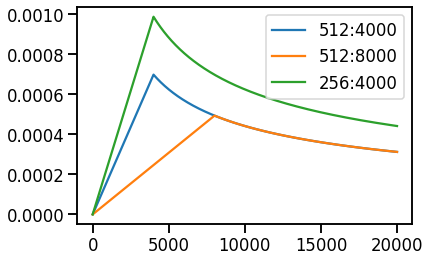

In [18]:
opts = [
    NoamOpt(512, 1, 4000, None), 
    NoamOpt(512, 1, 8000, None), 
    NoamOpt(256, 1, 4000, None)
]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])

## Regularization
### Label smoothing
During training, we employed label smoothing of value $\epsilon_{ls} = .1$. This hurts perplexity, as the model learns to be more unsure, but imporoves accuracy and BLEU score.

We implement label smoothing using the KL divergence loss. 
Instead of using a one-hot target distribution, we create a distribution that has confidence of the correct word and the rest of the smoothing mass distributed trhoughout the vocabulary.

In [19]:
class LabelSmoothing(nn.Module):
    """
    Implement label smoothing.
    """
    def __init__(self, size, padding_idx, smoothing=.0):
        """
        Input:
            - size (int): length of the distribution 
            - padding_idx (int?): column index of the padding
            - smoothing (float): smoothing is evenly distributed to 
                all non-padding and non-confidence entries in a distribution
        """
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction='sum')
        self.padding_idx = padding_idx
        self.confidence = 1 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        """
        Input:
            - x (tensor): Input distributions
            - target (tensor with integer values): where you want to put the confidence
        """
        
        assert x.size(1) == self.size
        
        true_dist = torch.zeros_like(x)
        true_dist.fill_(self.smoothing / (self.size - 2)) # distribution smoothing except the padding column
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0

        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0)

        self.true_dist = true_dist

        return self.criterion(x, Variable(true_dist, requires_grad=False))

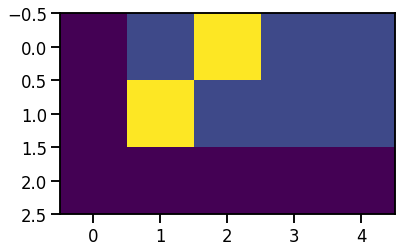

In [20]:
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(
    Variable(predict.log()), 
    Variable(torch.LongTensor([2, 1, 0]))
)
plt.imshow(crit.true_dist)

Label smoothing actually starts to penalize the model if it gets very confident about a given choice

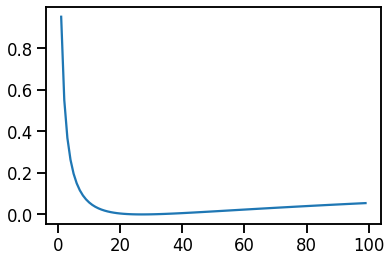

In [21]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])

# A First Example
We can begin by trying out a simple copy-task.
Given a random set of inptu symbols from a small vacabulary, the goal is to generate back those same symbols

## Synethic data

In [22]:
def data_gen(V, batch, nbatches):
    """
    Generate random data for a source-target copy task
    Input:
        - V (int): Upper limit of random integer (exclusive)
        - batch (int): the number of sentences in a batch
        - nbatches (int): the number of mini-batches
    NOTE 2: I have to add the the to(torch.int64) to fix a bug
    """
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False).to(torch.int64)
        tgt = Variable(data, requires_grad=False).to(torch.int64)
        yield Batch(src, tgt, 0)

## Loss Computation

In [23]:
class SimpleLossCompute:
    """
    A simple loss compute and train function.
    """
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
    
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(
            x.contiguous().view(-1, x.size(-1)),
            y.contiguous().view(-1)) / norm
        
        if self.opt is not None:
            loss.backward()
            self.opt.step()
            self.opt.optimizer.zero_grad()
        
        return loss.item() * norm

## Greedy Decoding

In [ ]:
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)

model_opt = NoamOpt(
    model.src_embed[0].d_model,
    1, # factor
    400, # warmup
    torch.optim.Adam(model.parameters(), lr=0, betas=(.9, .98), eps=1e-9)
)

epochs = 10
number_sentence_per_batch = 30
number_batches = 20
for epoch in range(epochs):
    print(f'Epoch {epoch + 1} / {epochs}')
    # tells your model that you are training the model. 
    # So effectively layers like dropout, batchnorm etc. 
    # which behave different on the train and test procedures 
    # know what is going on and hence can behave accordingly.
    model.train()
    run_epoch(
        data_gen(V, number_sentence_per_batch, number_batches), # 
        model,
        SimpleLossCompute(model.generator, criterion, model_opt),
        logging_freq=5
    )
    model.eval()
    
    valid_loss = run_epoch(
        data_gen(V, 30, 5),
        model, 
        SimpleLossCompute(model.generator, criterion, None),
        logging_freq=-1
    )
    print(f'\tValidation loss = {valid_loss}')
    

Epoch 1 / 10
torch.Size([30, 9, 512])
torch.Size([30, 10, 512])
torch.Size([30, 1, 10])
torch.Size([30, 9, 9])


## Predict translation using greedy decoding for simplicity

In [63]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    """
    Input:
        - model (nn.Module): the transformer model
        - src (Tensor): the input sentence of dimension (1 x n) where n is the length of the sentence including the start_symbol
        - src_mask (Tensor): source masking (1 x 1 x n)
        - max_len (int):
        - start_symbol (int): the symbol indict the start of the sentence.

    """
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len - 1):
        print(ys)
        out = model.decode(
            memory, 
            src_mask,
            Variable(ys),
            Variable(subsequent_mask(ys.size(1)).type_as(src.data))
        )
        prob = model.generator(out[:, -1])
        
        # print(prob)
        # torch.max return a tuple (max, max_indices)
        a, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        # print(next_word)
        ys = torch.cat([ys, torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

model.eval()
src = torch.Tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]).to(torch.int64)
src_mask = Variable(torch.ones(1, 1, 10))
translated = greedy_decode(model, src, src_mask, max_len=10, start_symbol=1)
print(f'\ntranslated = {translated}')